# <center>HW4</center> #
####  107061112 王昊文
***
## <u>Question 1</u>
1. For the Car Evaluation Data Set from UCI website (http://archive.ics.uci.edu/ml/
datasets/Car+Evaluation)

    1. Combine class value “unacc” and “acc” as one group, “good” and “vgood” as the other group, develop a model to identify the two groups.

    2. With the original four class values, develop a model to do multi-class classification of the four groups. (All features used)
    
    3. Use feature selection or extraction to develop a model for four group classification. Please also prepare some analysis for the model developed in 1.2 and 1.3 (performance, computation complexity required, ...).


## Implementaion

1. 使用Pandas處理資料，我們會利用內建的Library觀察資料的特性，是否有Imbalance？是否有缺少的資料？Feature或Label是否要做額外的Encoding?
2. 我會根據每題的要求，做適當的Training，Testing，以及Validation set的切割。
3. 再過去的作業中，我們幾乎都得到Random Forest，SVM，以及KNN的效果不錯。剛好這三個Model的特性都不太一樣，剛好可以拿來讓我們當比較的材料。我會去比較這三個的Performance，去得到我們最適合這題的Model。
4. 選擇Model的過程中，我們會透過K fold cross validation，以及Grid Search，根據Validation accuracy，去選我們的Hyperparameter。
5. 根據我們Cross validation的結果，去繪製Learning curve。根據Training accuracy以及Validation Accuracy是否收斂，當作我們的Model是否Overfitting，或Underfitting的判斷。這會是我們探討Model Performance一個很很大的重點。
6. 最後用我們切割的Testing set去評估Accuracy。如果是Binary classification，我們將會去探討Recall，Precision的Performance。
7. 再做Feature selection的時候，我們會先利用內建的Library，利用不同的Model去看，看看哪些是屬於重要的Feature，最後去評估是否可以去除一些不重要的Feature。另外我們也會測試PCA以及LDA的表現。

## Data Preprocess

### Read in the dataset

In [44]:
import pandas as pd
import numpy as np
df_car = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',header=None)
df_car.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'labels']
df_car

,buying,maint,doors,persons,lug_boot,safety,labels
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


看起來我們Feature以及Label需要做額外的Encoding。

### Checking each column

In [45]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   labels    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


There is no null object inside our dataset, which is great

### Feature ordinal encoding
Let's see what is in the features

In [46]:
df_car.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'labels'], dtype='object')

In [47]:
print(df_car['buying'].unique())
print(df_car['maint'].unique())
print(df_car['doors'].unique())
print(df_car['persons'].unique())
print(df_car['lug_boot'].unique())
print(df_car['safety'].unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['2' '3' '4' '5more']
['2' '4' 'more']
['small' 'med' 'big']
['low' 'med' 'high']


在這些Feature之中，我們發現幾乎都為Ordinal的Feature。如vhigh, med, low,彼此之間就存在著大小關係。人數也相同，因此我們手動去Map這些ordinal feature.

In [48]:
prize_mapping = {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
persons_mapping = {'2': 2, '4': 4, 'more': 5}
lug_boot_mapping = {'small': 0, 'med': 1, 'big': 2}
safety_mapping = {'low': 0, 'med': 1, 'high': 2}
df_car['buying'] = df_car['buying'].map(prize_mapping)
df_car['maint'] = df_car['maint'].map(prize_mapping)
df_car['doors'] = df_car['doors'].map(doors_mapping)
df_car['persons'] = df_car['persons'].map(persons_mapping)
df_car['lug_boot'] = df_car['lug_boot'].map(lug_boot_mapping)
df_car['safety'] = df_car['safety'].map(safety_mapping)
df_car

,buying,maint,doors,persons,lug_boot,safety,labels
0,3,3,2,2,0,0,unacc
1,3,3,2,2,0,1,unacc
2,3,3,2,2,0,2,unacc
3,3,3,2,2,1,0,unacc
4,3,3,2,2,1,1,unacc
...,...,...,...,...,...,...,...
1723,0,0,5,5,1,1,good
1724,0,0,5,5,1,2,vgood
1725,0,0,5,5,2,0,unacc
1726,0,0,5,5,2,1,good


根據上面，我們仍可以發現，label的部份也需要處理，因此下面使用Labelencoder來做

In [49]:
from sklearn.preprocessing import LabelEncoder

# print('Class Labels before preprocessing:', np.unique(df_car['labels'].values))
unique, counts = np.unique(df_car['labels'], return_counts=True)
print('Class Labels before preprocessing:', dict(zip(unique, counts)))
le = LabelEncoder()
df_car['labels'] = le.fit_transform(df_car['labels'])
unique, counts = np.unique(df_car['labels'], return_counts=True)
print("Class Label after transforming", dict(zip(unique, counts)))
df_car

Class Labels before preprocessing: {'acc': 384, 'good': 69, 'unacc': 1210, 'vgood': 65}
Class Label after transforming {0: 384, 1: 69, 2: 1210, 3: 65}


,buying,maint,doors,persons,lug_boot,safety,labels
0,3,3,2,2,0,0,2
1,3,3,2,2,0,1,2
2,3,3,2,2,0,2,2
3,3,3,2,2,1,0,2
4,3,3,2,2,1,1,2
...,...,...,...,...,...,...,...
1723,0,0,5,5,1,1,1
1724,0,0,5,5,1,2,3
1725,0,0,5,5,2,0,2
1726,0,0,5,5,2,1,1


我們可以發現我們的Data有很大的Imbalance的問題。但仔細觀察可以發現，幾乎Data都在uncacceptable以及Acceptatble兩類。對我們來說，判斷出車子不要買對我們來說比較重要，剛好我們Dataset不好的車子又特別多，因此這個Dataset中我們不考慮Sampling的作法(怕引發Overfitting或Underfitting)

### Split X and y

In [50]:
# first extract the labels
y = df_car['labels'].values
# extract the features
X = df_car.drop(columns = ['labels']).values
print('Class Labels:', np.unique(y))
print('Corresponding names:', le.inverse_transform(np.unique(y)))

Class Labels: [0 1 2 3]
Corresponding names: ['acc' 'good' 'unacc' 'vgood']


一切準備就緒。

## Question 1
Combine class value “unacc” and “acc” as one group, “good” and “vgood” as the other group, develop a model to identify the two groups.

### Map y for question 1
Since "unacc", "acc" and "good", "vgood" belongs to the same class, we need to do additional mapping
 
Recall: 'acc': 0, 'good': 1, 'unacc': 2, 'vgood': 3

In [51]:
# mapping the labels for question 1
q1map = {0: 0, 2: 0, 1: 1, 3: 1}
# y1 for question 1
y1 = df_car['labels'].map(q1map)
unique, counts = np.unique(y1, return_counts=True)
dict(zip(unique, counts))

{0: 1594, 1: 134}

資料上有很大的Imbalance問題，大部分的Label都落在acceptable跟uacceptable的區間，以下就簡稱這個叫做0。不過，從實務面來想，我們本來就比較希望我們的Dataset學習如何判斷0，正所謂「寧可錯殺，也不願放過」，我們寧可所有的車都被歸類成unacceptable，也不要一台車被歸類成good但其實是unacceptable。因此我認為這個問題並不大。

### Seperating test and Training Datasets
Using the library from sklearn

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=0, stratify=y1)
print('size of our training set:', X_train.shape[0])
print('size of our testing set:', X_test.shape[0])

size of our training set: 1209
size of our testing set: 519


到這邊我們應該要思考我們究竟要使用什麼Model比較好。我第一件想到的事情是我們資料本身就是離散的，直接拿來用Random Forest來訓練似乎相當直觀(Decision Tree也可以，但Random Forest直接ensemble效果強)。另外線性切割中SVM最強，因此我們使用它。

### Trying Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

forest = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=1, n_jobs=-1)
forest.fit(X_train, y1_train)


RandomForestClassifier(n_jobs=-1, random_state=1)

### Draw the learning curve

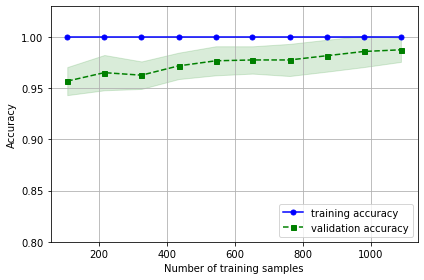

In [54]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
train_sizes, train_scores, test_scores = learning_curve(estimator=forest, X=X_train, y=y1_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

我們可以觀察到，在資料量比較小的時候稍微有Overfitting的問題，但隨著資料量上升，Training和Validation accuracy漸漸收斂在一起，象徵我們只要有更多Training data，就沒有Overfitting!另外我們的Training sample也超過1000，因此我們的Model沒有Overfitting的問題，表現也相當的好！

### Print the final results

In [55]:
y1_pred = forest.predict(X_test)
print('The results of our best model')
print('Missclassified examples: %d' %(y1_test != y1_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred))
print('Precision: %.3f' %precision_score(y_true=y1_test, y_pred=y1_pred))
print('Recall: %.3f' %recall_score(y_true=y1_test, y_pred=y1_pred))
print('F1: %.3f' %f1_score(y_true=y1_test, y_pred=y1_pred))

The results of our best model
Missclassified examples: 6
Accuracy: 0.988
Precision: 0.947
Recall: 0.900
F1: 0.923


在這個例子中，Precision比較重要，我們希望在所有positive case中選取真正positive的，正如前面提的我們不希望不好的車被歸類成Good那類的。在這裡有94.7%算滿意。Accuracy和其他指標等等都令人相當滿意。

### Print the confusion matrix

Text(0, 0.5, 'True label')

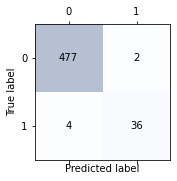

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confmat = confusion_matrix(y_true=y1_test, y_pred=y1_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j], va = 'center', ha = 'center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

在這個Case當中Random Forest以100棵Decision Tree做Ensemble就得到了很好的效果，他在Precision跟Accuracy以及F1 Score都有很好的表現。以下我們嘗試看看SVM的結果。

### Trying SVM for our problem
在這邊我透過Validation set去做Grid search去尋找最好的超參數，另外我這邊也有一起考慮Kernel SVM。Standard scaler處理的部份已經放在Pipeline當中了。

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.001, 0.0001, 0.01, 0.99, 1.0, 10.0, 100.0, 1000.0, 2, 3, 4, 5, 0.9, 0.8, 1.1]

# this will also include the kernel svm
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

# this only includes linear svm
# param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y1_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
gs = gs.fit(X_train, y1_train)
print(gs.best_params_)
clf = gs.best_estimator_


CV accuracy: 0.983 +/- 0.007
{'svc__C': 2, 'svc__gamma': 0.9, 'svc__kernel': 'rbf'}


在這裡我們的Grid Search找到了Kernel SVM，Training Accuracy初步看起來不錯，但極有可能有Overfitting的問題，以下繪製Learning curve 來測試。

### Plot the learning curve of the SVM model

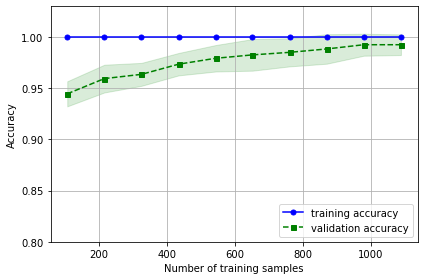

In [58]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train, y=y1_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

起初我有點擔心使用Kernel SVM會有Overfitting的問題，看起來這個問題似乎不大！當資料量足夠我們就不會有Overfitting，如圖所示我們的Training Accuracy以及Validation Accuracy都有收斂到一起。剛好這題有提供足夠的Dataset。

### Test our Kernel SVM model

In [59]:
clf.fit(X_train, y1_train)
y1_pred = clf.predict(X_test)
print('The testing results of our best model')
print('Missclassified examples: %d' %(y1_test != y1_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred))

The testing results of our best model
Missclassified examples: 5
Accuracy: 0.990


準確率良好！測試看看Precision是否也ok。

### Confusion Martix

Text(0, 0.5, 'True label')

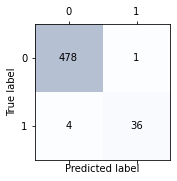

In [60]:
confmat = confusion_matrix(y_true=y1_test, y_pred=y1_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j], va = 'center', ha = 'center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

### Precision, F1... etc.

In [61]:
print('Precision: %.3f' %precision_score(y_true=y1_test, y_pred=y1_pred))
print('Recall: %.3f' %recall_score(y_true=y1_test, y_pred=y1_pred))
print('F1: %.3f' %f1_score(y_true=y1_test, y_pred=y1_pred))

Precision: 0.973
Recall: 0.900
F1: 0.935


Precision達到了97.3%，甚至比剛開始的Random Forest還要好！

Q1.1 summary:在第一小題中，使用Kernel SVM使用C = 2，gamma = 0.9, solver = 'rbf'的情況之下可以得到最好的Model。準確率來到98%，precision來到了97.3%，算是找到了相當強悍的Model。

## Question 2
With the original four class values, develop a model to do multi-class classification of the four groups. (All features used)

這題中我們應用上面的策略，使用SVM以及Random Forest試試看。另外如果以上有人表現不佳，也會嘗試看看KNN。另外因為這邊題目要求我們明確的分成四類，Precision的問題降低，我們這邊就不考慮，我們希望將Model的Accuracy拉到最高。

### Seperating training and testing datasets
這題與第一題不同，我們要分成四類。

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 269, 1: 48, 2: 847, 3: 45}

這裡因為要明確的做四類的Classification，資料imbalance就變得很棘手。我們嘗試把0, 1, 3類的拉到跟2一樣多。在這裡我們要注意，我僅僅Upsample Training dataset，剩下的Testing在前面已經分割出去，避免Training data裡面出現Testing data。

### Upsampling our training dataset to the amount as class 2
因為我們使用了upsampling，我們必須要小心Overfitting。

In [63]:
from sklearn.utils import resample
import numpy as np
print('X_train shape', X_train.shape)
print('X shape', X.shape)
X_imb = X_train
y_imb = y_train
print('Number of class 0 samples before', X_imb[y_imb == 0].shape[0])
X_upsampled0, y_upsampled0 = resample(X_imb[y_imb == 0], y_imb[y_imb == 0], replace=True, n_samples=X_imb[y_imb == 2].shape[0], random_state=123)
print('Number of class 0 samples after', X_upsampled0.shape[0])
print('Number of class 1 samples before', X_imb[y_imb == 1].shape[0])
X_upsampled1, y_upsampled1 = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 2].shape[0], random_state=123)
print('Number of class 1 samples after', X_upsampled1.shape[0])
print('Number of class 3 samples before', X_imb[y_imb == 3].shape[0])
X_upsampled3, y_upsampled3 = resample(X_imb[y_imb == 3], y_imb[y_imb == 3], replace=True, n_samples=X_imb[y_imb == 2].shape[0], random_state=123)
print('Number of class 3 samples after', X_upsampled3.shape[0])
X_upsampled = np.concatenate((X_upsampled0, X_imb[y_imb == 2], X_upsampled1, X_upsampled3), axis=0)
y_upsampled = np.concatenate((y_upsampled0, y_imb[y_imb == 2], y_upsampled1, y_upsampled3), axis=0)
unique, counts = np.unique(y_upsampled, return_counts=True)
dict(zip(unique, counts))



X_train shape (1209, 6)
X shape (1728, 6)
Number of class 0 samples before 269
Number of class 0 samples after 847
Number of class 1 samples before 48
Number of class 1 samples after 847
Number of class 3 samples before 45
Number of class 3 samples after 847


{0: 847, 1: 847, 2: 847, 3: 847}

### Split the data based on our upsampling result

In [64]:
X_train = X_upsampled
y_train = y_upsampled
X_test = X_test
y_test = y_test
unique, counts = np.unique(y_train, return_counts=True)
print('y_train', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('y_test', dict(zip(unique, counts)))

y_train {0: 847, 1: 847, 2: 847, 3: 847}
y_test {0: 115, 1: 21, 2: 363, 3: 20}


我們的Upsample的Data不包括Testing，以確保之後測試的準確性。

### Use randomforest to train the data

In [65]:
forest = RandomForestClassifier(criterion='gini', n_estimators=10, random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

### Draw the learning curve

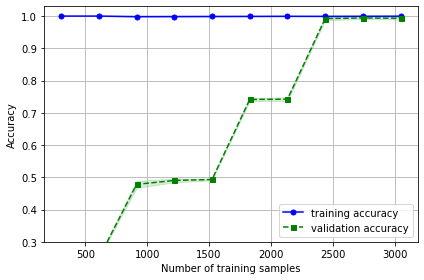

In [66]:
train_sizes, train_scores, test_scores = learning_curve(estimator=forest, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
plt.show()

由於我們upsample了我們Training set，我們要小心Overfitting的問題。當我們的Training sample逼近3000，Overfitting的問題不大。這個Model看起來不錯。
另外我們可以發現，Learning curve是階梯式的往上，畢竟我們的Training data裡面有很多重複的Data，這是可以預期的。

### Testing results of our random forest model

In [67]:
y_pred = forest.predict(X_test)
print('The results of our best model')
print('Missclassified examples: %d' %(y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

The results of our best model
Missclassified examples: 22
Accuracy: 0.958


在Testing的結果大約有96%，結果算是令人滿意。

### Try the SVM model
一樣使用Grid search以及k fold cross validation來尋找最好的Model。在這裡我有開啟Kernel SVM的選項，先測試看看他是不是我們最好的Model，然後有無Overfitting的問題，Training set也是使用前面的Upsample過的。

In [68]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.001, 0.0001, 0.01, 0.99, 1.0, 10.0, 100.0, 1000.0, 2, 3, 4, 5, 0.9, 0.8, 1.1, 0.7, 0.6]

# this will also include the kernel svm
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

# this only includes linear svm
# param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
clf = gs.best_estimator_

CV accuracy: 0.999 +/- 0.002
{'svc__C': 10.0, 'svc__gamma': 0.9, 'svc__kernel': 'rbf'}


Training Accuracy很高，看看Overfitting的狀況。

### Plot the learning curve of the SVM model

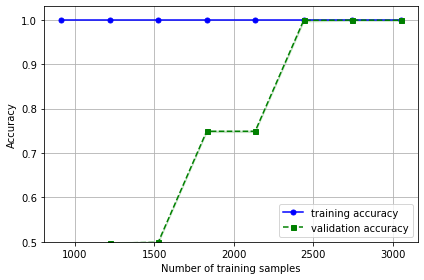

In [69]:
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])
plt.tight_layout()
plt.show()

得到與前一題差不多的Learning curve，在最後的時候Accuracy都有收斂在一起。

### Testing our SVM model

In [70]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('The results of our best model')
print('Missclassified examples: %d' %(y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

The results of our best model
Missclassified examples: 15
Accuracy: 0.971


在這裡看起來Kernel SVM效果與Random Forest差不多，Kernel SVM似乎高了一些。以下測試KNN。

### Try KNN
在最後測試一下KNN的效果如何

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

pip_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(p=2, metric='minkowski'))])

param_range = [ 5, 6, 7, 8, 9, 10, 11, 12, 13]
param_grid = [{'knn__n_neighbors': param_range}]
gs = GridSearchCV(estimator=pip_knn, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
clf = gs.best_estimator_

CV accuracy: 0.968 +/- 0.005
{'knn__n_neighbors': 5}


我們Grid Search排除掉了nn低的部份，稍微提昇一下Model對抗Overfitting的能力。

### Plot the learning curve of KNN

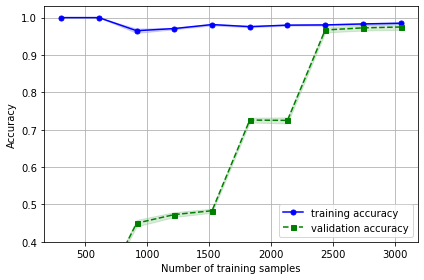

In [72]:
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.4, 1.03])
plt.tight_layout()
plt.show()

結果看起來令人相當滿意，測試看看Testing結果。

### Test the KNN model

In [73]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('The results of our best model')
print('Missclassified examples: %d' %(y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

The results of our best model
Missclassified examples: 38
Accuracy: 0.927


可以看到KNN的準確率比較低。

Q2 Summary: 在這題之中，Kernel SVM表現最好，Random Forest表現也相當不錯。整而言三種演算法都有超過九成的準確率，都不錯。如果我們Testing要在硬體空間比較小的地方做或者Dataset變大，KNN可能就會吃虧，畢竟他在Testing的時候要記住所有Training data，通常我們要將Model提供給他人使用，Testing的時候等太久不是一件好事。

在這個例子中，如果考慮上面提到的Testing問題，RBF SVM以及Random Forest都是一個好的選擇。但由於RBF牽涉到Exponential的運算，運算資源消耗較多，因此最後結論，Random Forest會是我的第一選擇

## Question 3
Use feature selection or extraction to develop a model for four group classification.

### Feature Selection
以下我們使用Random forest來觀察Feature的重要性。我們在這邊使用我們在前面已經Upsample過得Training set來做檢驗。

 1) safety                         0.280504
 2) buying                         0.199727
 3) maint                          0.187096
 4) persons                        0.137611
 5) lug_boot                       0.135760
 6) doors                          0.059301


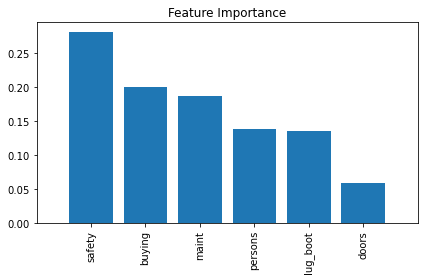

In [74]:
feat_labels = df_car.columns[:-1]
forest = RandomForestClassifier(n_estimators = 500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' %(f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align = 'center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### Use logistic regression for feature selection

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
lsvc = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', multi_class='ovr', random_state=0).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print("The most important features are:")
print(feat_labels[model.get_support() == True])

The most important features are:
Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')


通過以上的分析，我們可以發現似乎很難去選擇不重要的Feature，如果我們想透過Feature Selection將複雜度降到三個維度以下的話，似乎有點困難，畢竟前三重要的Feature都佔比很大，Feature selection部份也把所有的Feature都列到了重要Feature。任意拿掉可能導致我們Model undefitting。我們下面透果LDA以及PCA的方法試試看。

前面的例子中Kernel SVM都表現不錯，以下我們就用Kernel SVM來做pca和lda。

### SVM with LDA
在如此複雜的模型中，我認為僅讓n=2應該會大幅度的Underfitting，因此我將資料轉成3個維度。

In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=3)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
svc = SVC(random_state=1)
param_range = [0.001, 0.0001, 0.01, 0.9, 0.8, 1.1, 0.7, 0.6]

# this will also include the kernel svm
param_grid = [{'C': param_range, 'gamma': [1], 'kernel': ['rbf']}]
# this only includes linear svm
# param_grid = [{'C': param_range, 'kernel': ['linear']}]

gs = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train_lda, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
gs = gs.fit(X_train_lda, y_train)
print(gs.best_params_)
clf = gs.best_estimator_

CV accuracy: 0.961 +/- 0.008
{'C': 1.1, 'gamma': 1, 'kernel': 'rbf'}


### Plotting the learning curve

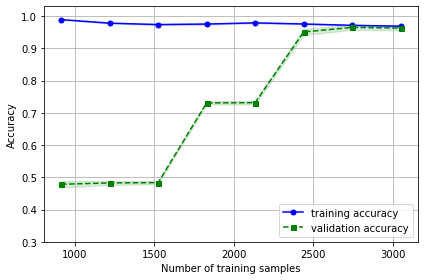

In [76]:
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train_lda, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
plt.show()

### Test the data

In [77]:
y_pred = clf.predict(X_test_lda)
print('The results of our best model')
print('Missclassified examples: %d' %(y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

The results of our best model
Missclassified examples: 46
Accuracy: 0.911


準確率比起用全部Feature準確率似乎下降了一些，但結果算是令人滿意。以下我們嘗試看看PCA

### SVM with PCA

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_pca = pca.fit_transform(X_train_std, y_train)
X_test_pca = pca.transform(X_test_std)
svc = SVC(random_state=1)
param_range = [0.001, 0.0001, 0.01, 0.9, 0.8, 1.1, 0.7, 0.6]

# this will also include the kernel svm
param_grid = [{'C': param_range, 'gamma': [1], 'kernel': ['rbf']}]
# this only includes linear svm
# param_grid = [{'C': param_range, 'kernel': ['linear']}]

gs = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train_pca, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
gs = gs.fit(X_train_pca, y_train)
print(gs.best_params_)
clf = gs.best_estimator_

CV accuracy: 0.831 +/- 0.016
{'C': 0.9, 'gamma': 1, 'kernel': 'rbf'}


### Plot the learning curve

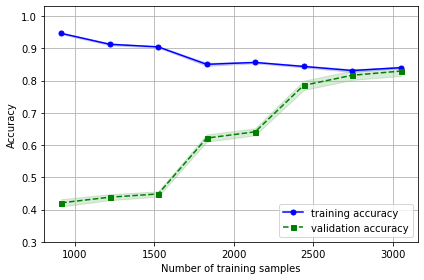

In [79]:
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train_pca, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
plt.show()

似乎得到了嚴重的Undefitting，不考慮使用PCA。從本質來看，PCA本身就沒有要Increase separability，準確率大幅下降是正常的。為了確保LDA真的可行，我們以下在拿其他Model測試看看。

### Try KNN with LDA
為了確認LDA是好辦法，我們將KNN一起納入討論

In [80]:
lda = LDA(n_components=3)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
knn = KNeighborsClassifier(p=2, metric='minkowski')
param_range = [8, 9, 10, 11, 12, 13, 14, 15, 16]
param_grid = [{'n_neighbors': param_range}]

gs = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train_lda, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
gs = gs.fit(X_train_lda, y_train)
print(gs.best_params_)
clf = gs.best_estimator_

CV accuracy: 0.969 +/- 0.008
{'n_neighbors': 8}


### Plot the learning curve for LDA KNN

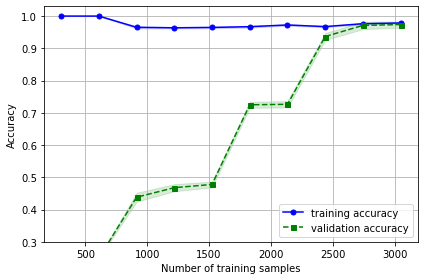

In [81]:
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train_lda, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
plt.show()

結果還不錯，但比起我們全用的時候準Training accuracy下降了一些。

### Test KNN with LDA

In [82]:
y_pred = clf.predict(X_test_lda)
print('The results of our best model')
print('Missclassified examples: %d' %(y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

The results of our best model
Missclassified examples: 47
Accuracy: 0.909


### Test random forest with LDA

In [83]:
lda = LDA(n_components=3)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
forest = RandomForestClassifier(criterion='gini', n_estimators=10, random_state=1, n_jobs=-1)
forest.fit(X_train_lda, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

### Plot the learning curve of random forest

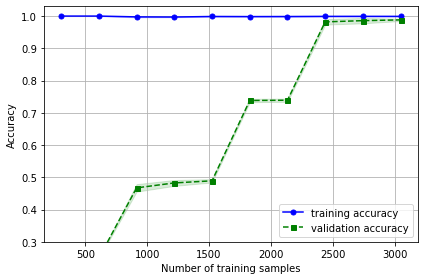

In [84]:
train_sizes, train_scores, test_scores = learning_curve(estimator=forest, X=X_train_lda, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
plt.show()

### Test our random forest model

In [85]:
y_pred = forest.predict(X_test_lda)
print('The results of our best model')
print('Missclassified examples: %d' %(y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

The results of our best model
Missclassified examples: 55
Accuracy: 0.894


準確率仍維持一定水準，但Testing準確率降低了大概5個百分點。

測試結果來看，LDA似乎是Feature extraction最好的方法，我們的確有效降低維度。但在資料本身Data偏複雜，做了LDA之後會稍微的比起全用的效果差一點點。

Q3 Summary: 這題中Feature Selection僅能做到有限度將低複雜度，正如我們看到Feature Importance那張圖，前面的Feature importace都很高，我們也只能從六個Feature降低到五個。然而，使用LDA可以將複雜度降到3個維度，仍保持一定的準確率，但準確率比起全用來的低，稍微低了4-5個百分點左右。

## Summary
1. 第一題中，由於是作Binary Classification，必須考慮Precision的問題。針對Imbalance的部份，我們考慮了實務面的問題，因此我們並沒有去對Data做Resample。SVM使用C = 2，gamma = 0.9, solver = 'rbf'得到了99%的準確率以及97.3%的Precision，Model沒有Overfitting的問題。另外如果考慮到RBF SVM exponential運算的問題，使用線性的Random Forest也是一個可靠的選擇，有98%的準確率以及94%的Precision。
2. 第二題中，因為我們要做四個Class的Classification，Dataset的平衡變得很重要。在切割完之後，SVM使用C = 10，gamma = 0.9, solver = 'rbf'，達到了97%的準確率，Model沒有Overfitting的問題。若考慮線性Classifier的話，Random Forest也是個可靠的選擇，有96%的準確率。另外我們也嘗試了KNN，在n==5的時候也有92.7%的準確度，但我們upsample之後有接近3000比的Training data，這對user端在Testing的時候會是一個很大的負擔。
3. 第三題中，我們利用Random Forest以及Logistic Regression去做Feature Selection。然而，我們發現兩者選出來的Feature很不一樣，甚至Logistic Regression顯示所有Feature都很重要。這顯示了直接捨棄Feature不是一個很好的作法。我們嘗試了PCA和LDA，發現了將維度壓到3d的時候LDA表現仍可以維持一定水準，但相較於使用全部的時候準確率低了大約5個百分點。當我們Data大幅增加時，LDA是一個可靠的作法，但是因為我們前面Model都沒有明顯Overfitting的問題，因此我認為使用LDA的意義不大，除非我們有要拿來做Visualize的用途。但是因為Dataset本身比較複雜，壓到兩個的時候準確率會掉很多，因此Feature extraction或Selection在這個Dataset上面意義並不大。



## 心得
這次作業的Task看似與之前差不多，但因為上課教的東西變多了，我們要考慮的東西更深層了。這次的作業最令人有成就感的就是我們所建立的Model是可以在實際中應用的，畢竟之前我們沒有考慮Overfitting。在這次的作業我們也處理了不平衡的Dataset，這感覺是日常生活中非常容易出現的問題，能透過這次練習一次，讓我們的功力大增。